In [1]:
# Gerekli kütüphaneleri yükleyin
import os
import shutil
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import warnings
import itertools

# Uyarıları gizle
warnings.filterwarnings("ignore")

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

# Keras ve TensorFlow
import keras
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_accuracy

# TensorFlow applications (MobileNet, ResNet vb.)
from tensorflow.keras.applications import MobileNet, ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

In [2]:
# Eğitim ve Doğrulama Görüntüleri için Yollar
train_path ='C:/Users/esraa/Desktop/base_dir/train_dir'
valid_path ='C:/Users/esraa/Desktop/base_dir/val_dir'

In [3]:
#dosya listelenmesi
def getListOfFiles(dirName):
    listOfFile = os.listdir(dirName)
    allFiles = list()
    for entry in listOfFile:
        fullPath = os.path.join(dirName, entry)
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
    return allFiles

In [4]:
#Görüntü İşleme Fonksiyonu
def image_to_feature_vector(image, size=(224, 224)):
    return cv2.resize(image, size).flatten()

In [5]:
# ### GPU'nun uygunluğunu kontrol etme
# from keras import backend as K
# K.tensorflow_backend._get_available_gpus()

In [6]:
def get_files(directory):
    if not os.path.exists(directory):
        return 0
    count = 0
    for current_path, dirs, files in os.walk(directory):
        for dr in dirs:
            count += len(glob.glob(os.path.join(current_path, dr + "/*")))
    return count

In [7]:
# Girdi görüntüsünün yükseklik, genişlik ve renk ayarı.
IMG_CHANNELS = 3
IMG_ROWS = 224
IMG_COLS = 224
input_shape = (IMG_ROWS, IMG_COLS ,3)

# ### Eğitim ve Doğrulama Örnek Sayıları
train_samples_num = get_files(train_path)
val_samples_num = get_files(valid_path)
print(train_samples_num)
print(val_samples_num)


# Model eğitim ayarları
epochs = 30
train_batch_size = 64
val_batch_size = 64
image_size = 224

# Bir iterasyonda kaç adım gerektiğini bildirme
train_steps = train_samples_num // train_batch_size
val_steps = val_samples_num // val_batch_size



36529
3673


In [8]:
data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_batches = data_gen.flow_from_directory(train_path,
                                             target_size=(image_size, image_size),
                                             batch_size=train_batch_size,
                                             color_mode='rgb',
                                             class_mode='categorical'
                                             )

valid_batches = data_gen.flow_from_directory(valid_path,
                                             target_size=(image_size, image_size),
                                             batch_size=val_batch_size,
                                             color_mode='rgb',
                                             class_mode='categorical'
                                             )

test_batches = data_gen.flow_from_directory(valid_path,
                                            target_size=(image_size, image_size),
                                            batch_size=val_batch_size,
                                            shuffle=False,
                                            color_mode='rgb',
                                            class_mode='categorical'
                                            )


Found 36529 images belonging to 7 classes.
Found 3673 images belonging to 7 classes.
Found 3673 images belonging to 7 classes.


In [9]:
# Modeli düzenleme

resnet_model = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)


x = resnet_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(7, activation='softmax')(x)

# Yeni çıktılı bir model oluşturma
# Changed densenet_model to resnet_model
model = tf.keras.Model(inputs=resnet_model.input, outputs=predictions)

# Modeldeki yeni katmanların özetine bakma
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 26,476,935 (101.00 MB)

 Trainable params: 26,423,815 (100.80 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [10]:
model.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

# Modeli save etmek için checkpoint bildirimi
filepath = "C:/Users/esraa/Desktop/base_dir/resnet_model.keras" # Changed .h5 to .keras

checkpoint = ModelCheckpoint(filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.5,
                              patience=2,
                              verbose=1,
                              mode='min',
                              min_lr=0.00001)

callbacks_list = [checkpoint, reduce_lr]


In [11]:
history = model.fit(train_batches,
                    steps_per_epoch=train_steps,
                    validation_data=valid_batches,
                    validation_steps=val_steps,
                    epochs=epochs,
                    verbose=1,
                    callbacks=callbacks_list)


Epoch 1/30
570/570 ━━━━━━━━━━━━━━━━━━━━ 0s 24s/step - accuracy: 0.2665 - loss: 2.5637 
Epoch 1: val_loss improved from inf to 2.93375, saving model to C:/Users/esraa/Desktop/base_dir/resnet_model.keras
570/570 ━━━━━━━━━━━━━━━━━━━━ 13653s 24s/step - accuracy: 0.2666 - loss: 2.5624 - val_accuracy: 0.2804 - val_loss: 2.9338 - learning_rate: 0.0100
Epoch 2/30
  1/570 ━━━━━━━━━━━━━━━━━━━━ 4:15:27 27s/step - accuracy: 0.3594 - loss: 1.5432
Epoch 2: val_loss improved from 2.93375 to 2.68517, saving model to C:/Users/esraa/Desktop/base_dir/resnet_model.keras
570/570 ━━━━━━━━━━━━━━━━━━━━ 219s 337ms/step - accuracy: 0.3594 - loss: 1.5432 - val_accuracy: 0.3172 - val_loss: 2.6852 - learning_rate: 0.0100
Epoch 3/30
570/570 ━━━━━━━━━━━━━━━━━━━━ 0s 25s/step - accuracy: 0.4603 - loss: 1.4021 
Epoch 3: val_loss improved from 2.68517 to 1.66738, saving model to C:/Users/esraa/Desktop/base_dir/resnet_model.keras
570/570 ━━━━━━━━━━━━━━━━━━━━ 14329s 25s/step - accuracy: 0.4603 - loss: 1.4021 - val_accurac

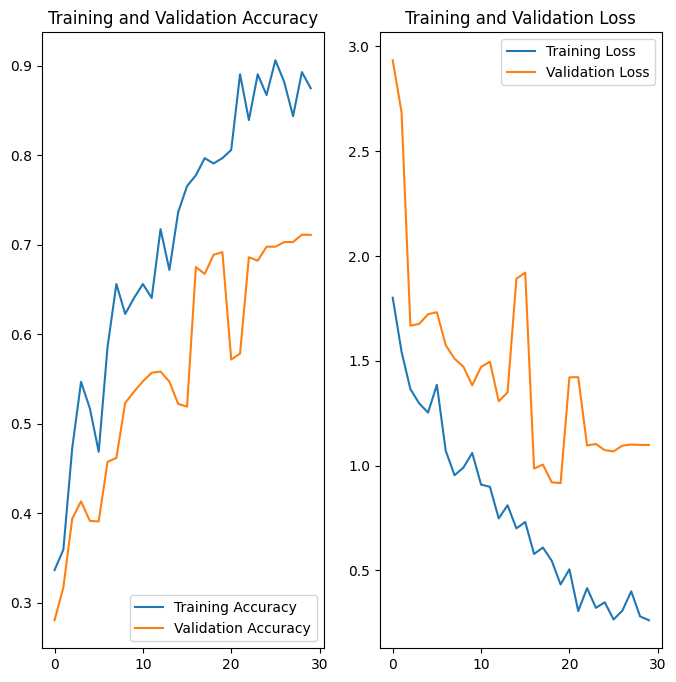

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [17]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Modelin tahminlerini al
test_labels = test_batches.classes
predictions = model.predict(test_batches, verbose=1)
predicted_classes = predictions.argmax(axis=1)

# Hassasiyet, geri çağırma, F1 skor hesaplama
precision = precision_score(test_labels, predicted_classes, average='weighted')
recall = recall_score(test_labels, predicted_classes, average='weighted')
f1 = f1_score(test_labels, predicted_classes, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')


58/58 ━━━━━━━━━━━━━━━━━━━━ 186s 3s/step
Precision: 0.6940743833096763
Recall: 0.6915328069697795
F1 Score: 0.6833960824678194


In [14]:
# Modeli değerlendirme
val_loss, val_acc = model.evaluate(test_batches, steps=val_steps)
print('val_loss:', val_loss)
print('val_cat_acc:', val_acc)

# Model ağırlıklarını yükleme
model.load_weights(filepath)

57/57 ━━━━━━━━━━━━━━━━━━━━ 180s 3s/step - accuracy: 0.6150 - loss: 1.4541
val_loss: 1.1020500659942627
val_cat_acc: 0.7099780440330505


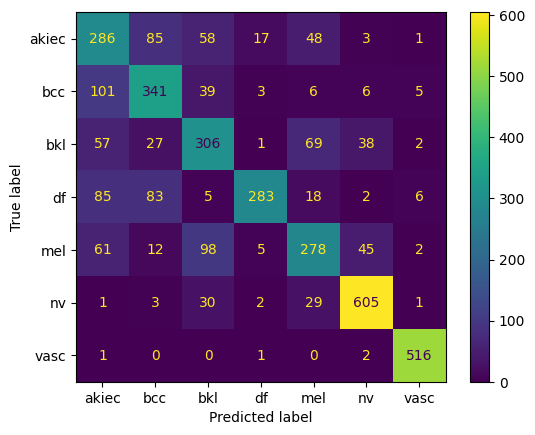

In [15]:
# Confusion matrisi oluşturma
cm = confusion_matrix(test_labels, predicted_classes)
cm_plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

# Confusion matrisini görselleştirme
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cm_plot_labels)
disp.plot()
plt.show()

58/58 ━━━━━━━━━━━━━━━━━━━━ 168s 3s/step
Normalized Confusion Matrix
[[0.32730924 0.26506024 0.18674699 0.07228916 0.14457831 0.00401606
  0.        ]
 [0.06786427 0.82235529 0.0499002  0.03992016 0.00598802 0.01397206
  0.        ]
 [0.042      0.098      0.568      0.04       0.168      0.082
  0.002     ]
 [0.08713693 0.2033195  0.01452282 0.64315353 0.04356846 0.00622407
  0.00207469]
 [0.03393214 0.0499002  0.25748503 0.03792415 0.50499002 0.11177645
  0.00399202]
 [0.         0.00596125 0.05663189 0.01490313 0.02235469 0.89865872
  0.00149031]
 [0.         0.00384615 0.         0.         0.         0.00576923
  0.99038462]]


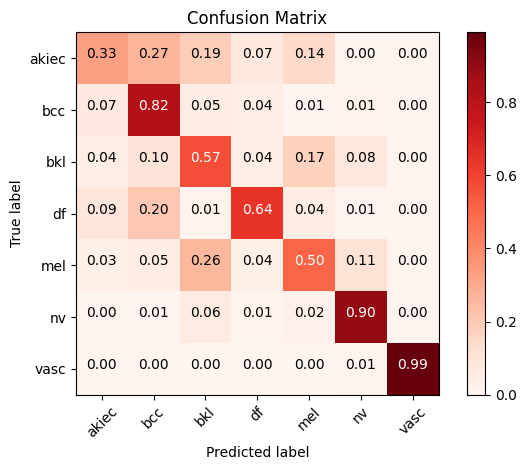

In [19]:
# Test görüntülerinin confusion matrisini oluşturma
test_labels = test_batches.classes

# Tahmin yapma
predictions = model.predict(test_batches, test_batches.n//test_batches.batch_size+1, verbose=1)
predictions = np.argmax(predictions, axis=1)

# Confusion matrisi fonksiyonu
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion Matrix', cmap=plt.cm.Reds):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized Confusion Matrix")
    else:
        print('Confusion Matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(test_labels, predictions)
cm_plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
plot_confusion_matrix(cm, cm_plot_labels)


image shape: (224, 224, 3)


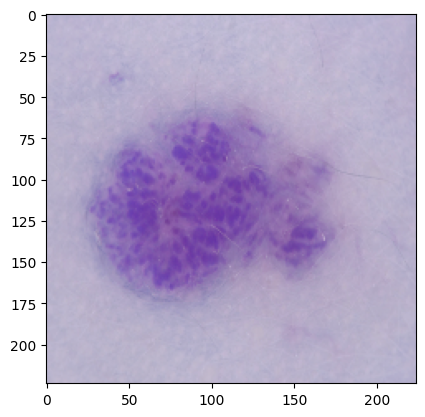

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[[3.53055686e-04 1.23331295e-02 1.43745560e-02 1.29319308e-03
  1.64953377e-02 2.00671956e-01 7.54478812e-01]]
vasc


In [20]:
img_test = cv2.imread(valid_path+'/vasc/ISIC_0026876.jpg')
# Resizing image
img_scaled = cv2.resize(img_test,(image_size,image_size))
img_test = tf.image.convert_image_dtype(img_scaled, dtype=tf.float32,
                                        saturate=False)
print("image shape: {}".format(img_test.shape))
plt.imshow(img_test)
plt.show()
#img_test = img_test/255.

img_test = np.expand_dims(img_test, axis=0)
# getting model predictions
test_predictions = model.predict(img_test)
print(test_predictions)
predicted_label = np.argmax(test_predictions)

print(cm_plot_labels[predicted_label])

In [22]:
# .keras modelini yükleme
model = tf.keras.models.load_model("C:/Users/esraa/Desktop/base_dir/resnet_model.keras")

# Modeli .h5 formatında kaydetme
model.save("C:/Users/esraa/Desktop/base_dir/resnet_model.h5")
